In [109]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import xgboost as xgb

from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon

from tabulate import tabulate

# **Wind Farm #2**

In [110]:
DATA_PATH = 'Datasets'

df_wf1 = pd.read_excel(
    os.path.join(DATA_PATH,'Wind farm site 2 (Nominal capacity-200MW).xlsx'), 
)

pd.set_option('display.max_columns', None)
df_wf1

,Time(year-month-day h:m:s),Wind speed at height of 10 meters (m/s),Wind direction at height of 10 meters (˚),Wind speed at height of 30 meters (m/s),Wind direction at height of 30 meters (˚),Wind speed at height of 50 meters (m/s),Wind direction at height of 50 meters (˚),Wind speed - at the height of wheel hub (m/s),Wind speed - at the height of wheel hub (˚),Air temperature (°C),Atmosphere (hpa),Power (MW)
0,2019-01-01 00:00:00,2.951,124.685,4.634,114.568,3.869,102.139,2.645,103.023,-12.735,887.187,33.451336
1,2019-01-01 00:15:00,2.951,129.697,2.951,118.488,2.951,97.463,2.186,108.914,-12.992,887.227,36.811337
2,2019-01-01 00:30:00,2.951,124.756,3.563,118.210,2.798,91.528,2.492,97.322,-12.745,887.094,31.172535
3,2019-01-01 00:45:00,2.186,129.019,2.339,112.761,2.339,94.015,1.281,99.393,-12.904,887.214,27.836002
4,2019-01-01 01:00:00,2.033,121.358,1.880,105.626,2.186,99.392,2.186,95.703,-12.979,887.227,31.192802
...,...,...,...,...,...,...,...,...,...,...,...,...
70171,2020-12-31 22:45:00,2.518,123.296,2.747,103.838,2.518,89.739,2.874,94.430,-12.889,887.686,0.045933
70172,2020-12-31 23:00:00,0.840,100.233,2.302,89.572,2.724,80.741,2.592,93.190,-13.337,887.717,0.080467
70173,2020-12-31 23:15:00,0.409,86.624,1.727,103.470,2.288,94.421,2.237,97.814,-13.889,887.464,0.000000
70174,2020-12-31 23:30:00,0.037,114.375,1.168,99.424,1.523,85.928,1.778,89.808,-13.543,887.282,0.000000


In [111]:
df_wf1.columns=['time','WS_10','WD_10','WS_30','WD_30','WS_50','WD_50','WS_cen','WD_cen','Air_T','Air_P','Power(MW)']

In [112]:
"""
deviation_cen = np.abs(df_wf1['WD_cen'] - 90)  # Deviation from 90 degrees
deviation_cen = np.minimum(deviation_cen, np.abs(df_wf1['WD_cen'] - 270))  # Deviation from 270 degrees
 
# Normalize deviations to range between -1 and 1
min_deviation_cen = np.min(deviation_cen)
max_deviation_cen = np.max(deviation_cen)
normalized_deviation_cen = (2 * (deviation_cen - min_deviation_cen) / (max_deviation_cen - min_deviation_cen)) - 1
 
# Replace original wind direction values with normalized deviations for WD_cen column
df_wf1['WD_cen'] = normalized_deviation_cen
 
# Now you can use df_wf1 with modified WD_cen column along with other variables for further analysis or modeling.
"""

"\ndeviation_cen = np.abs(df_wf1['WD_cen'] - 90)  # Deviation from 90 degrees\ndeviation_cen = np.minimum(deviation_cen, np.abs(df_wf1['WD_cen'] - 270))  # Deviation from 270 degrees\n \n# Normalize deviations to range between -1 and 1\nmin_deviation_cen = np.min(deviation_cen)\nmax_deviation_cen = np.max(deviation_cen)\nnormalized_deviation_cen = (2 * (deviation_cen - min_deviation_cen) / (max_deviation_cen - min_deviation_cen)) - 1\n \n# Replace original wind direction values with normalized deviations for WD_cen column\ndf_wf1['WD_cen'] = normalized_deviation_cen\n \n# Now you can use df_wf1 with modified WD_cen column along with other variables for further analysis or modeling.\n"

In [113]:
df_wf1.columns = [col.strip() for col in df_wf1.columns]

In [114]:
df_wf1.describe()

,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Power(MW)
count,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000
mean,6.325568,218.598444,7.160943,217.546658,7.400046,209.723608,7.558165,207.748026,8.665843,883.222322,72.705279
std,4.021242,85.720104,4.485920,88.465678,4.644244,86.128863,4.863350,85.819192,13.231113,7.903121,55.735581
min,0.000000,0.008000,0.000000,0.000000,0.000000,0.009000,0.000000,0.063000,-24.547000,441.272000,0.000000
25%,3.104000,136.637250,3.538000,123.996250,3.563000,115.306500,3.410000,114.752000,-3.578250,880.643000,14.027617
50%,6.470000,250.564000,7.337000,266.412000,7.541000,257.695000,7.683000,244.942000,10.293500,884.053000,75.401173
75%,9.134000,296.102250,10.163000,295.178000,10.480000,285.124250,10.796000,283.839500,19.958000,887.559000,124.313402
max,23.300000,359.916000,27.125000,360.000000,28.196000,359.889000,28.808000,359.802000,37.590000,900.450000,201.248080


In [115]:
df_wf1[df_wf1['Power(MW)'] == 0.0]

,time,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Power(MW)
37,2019-01-01 09:15:00,3.716,249.850,3.869,271.590,3.563,261.793,2.339,269.041,-14.361,885.658,0.0
38,2019-01-01 09:30:00,3.104,249.203,3.257,274.420,3.257,263.259,2.339,267.185,-14.086,885.950,0.0
39,2019-01-01 09:45:00,3.563,240.753,3.410,261.884,2.951,254.177,2.492,246.455,-13.737,885.936,0.0
42,2019-01-01 10:30:00,3.716,253.416,2.645,282.632,2.492,284.069,1.574,301.407,-13.842,886.655,0.0
43,2019-01-01 10:45:00,2.645,255.382,2.492,284.186,1.880,277.745,0.223,304.039,-13.358,886.868,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
70164,2020-12-31 21:00:00,3.410,140.891,3.614,124.231,3.028,103.607,1.931,183.208,-12.308,888.379,0.0
70165,2020-12-31 21:15:00,3.538,143.009,3.665,124.002,3.512,116.932,3.028,124.811,-12.464,888.392,0.0
70166,2020-12-31 21:30:00,3.240,136.660,3.693,122.227,3.920,115.547,3.608,125.296,-12.233,888.336,0.0
70173,2020-12-31 23:15:00,0.409,86.624,1.727,103.470,2.288,94.421,2.237,97.814,-13.889,887.464,0.0


In [116]:
df_wf1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70176 entries, 0 to 70175
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       70176 non-null  object 
 1   WS_10      70176 non-null  float64
 2   WD_10      70176 non-null  float64
 3   WS_30      70176 non-null  float64
 4   WD_30      70176 non-null  float64
 5   WS_50      70176 non-null  float64
 6   WD_50      70176 non-null  float64
 7   WS_cen     70176 non-null  float64
 8   WD_cen     70176 non-null  float64
 9   Air_T      70176 non-null  float64
 10  Air_P      70176 non-null  float64
 11  Power(MW)  70176 non-null  float64
dtypes: float64(11), object(1)
memory usage: 6.4+ MB


In [117]:
df_wf1['time'] = pd.to_datetime(df_wf1['time'], format='%Y-%m-%d %H:%M:%S')

In [118]:
df_wf1.isnull().mean()

time         0.0
WS_10        0.0
WD_10        0.0
WS_30        0.0
WD_30        0.0
WS_50        0.0
WD_50        0.0
WS_cen       0.0
WD_cen       0.0
Air_T        0.0
Air_P        0.0
Power(MW)    0.0
dtype: float64

In [119]:
df_wf1

,time,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Power(MW)
0,2019-01-01 00:00:00,2.951,124.685,4.634,114.568,3.869,102.139,2.645,103.023,-12.735,887.187,33.451336
1,2019-01-01 00:15:00,2.951,129.697,2.951,118.488,2.951,97.463,2.186,108.914,-12.992,887.227,36.811337
2,2019-01-01 00:30:00,2.951,124.756,3.563,118.210,2.798,91.528,2.492,97.322,-12.745,887.094,31.172535
3,2019-01-01 00:45:00,2.186,129.019,2.339,112.761,2.339,94.015,1.281,99.393,-12.904,887.214,27.836002
4,2019-01-01 01:00:00,2.033,121.358,1.880,105.626,2.186,99.392,2.186,95.703,-12.979,887.227,31.192802
...,...,...,...,...,...,...,...,...,...,...,...,...
70171,2020-12-31 22:45:00,2.518,123.296,2.747,103.838,2.518,89.739,2.874,94.430,-12.889,887.686,0.045933
70172,2020-12-31 23:00:00,0.840,100.233,2.302,89.572,2.724,80.741,2.592,93.190,-13.337,887.717,0.080467
70173,2020-12-31 23:15:00,0.409,86.624,1.727,103.470,2.288,94.421,2.237,97.814,-13.889,887.464,0.000000
70174,2020-12-31 23:30:00,0.037,114.375,1.168,99.424,1.523,85.928,1.778,89.808,-13.543,887.282,0.000000


Power(MW) column deals with 0.0 values, hence we will remove these rows to have realistic MAPE calculations.

## **Pairplots**

In [120]:
#sns.pairplot(df_wf1, hue=None, size=2.5)

## **Correlation matrix**

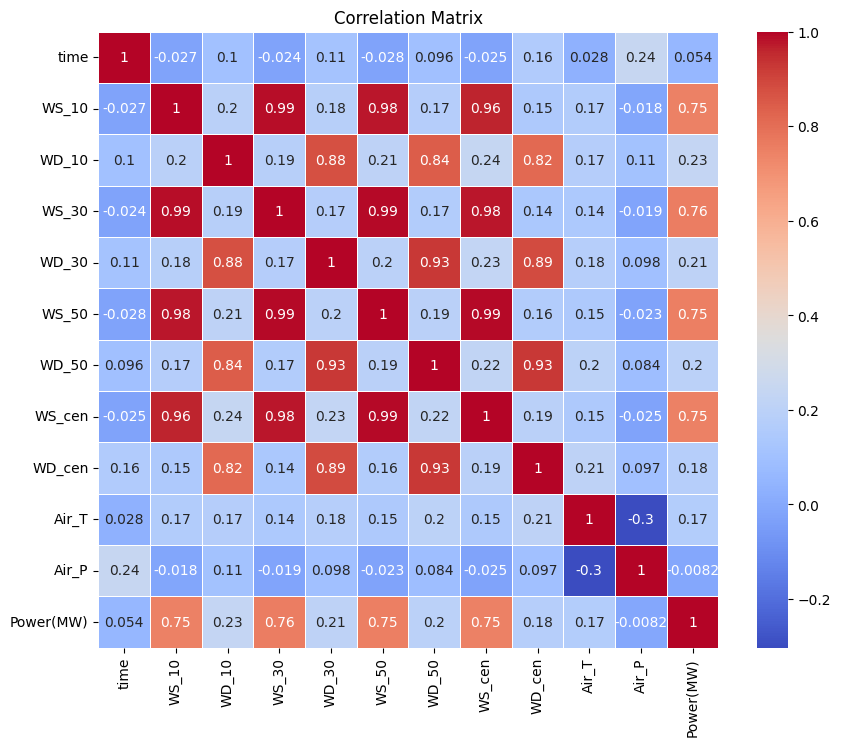

In [121]:
correlation_matrix = df_wf1.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [122]:
pearsonr(df_wf1['WS_10'], df_wf1['Power(MW)'])

PearsonRResult(statistic=0.7495615579403859, pvalue=0.0)

In [123]:
pearsonr(df_wf1['WS_30'], df_wf1['Power(MW)'])

PearsonRResult(statistic=0.7605587129513947, pvalue=0.0)

In [124]:
pearsonr(df_wf1['WS_50'], df_wf1['Power(MW)'])

PearsonRResult(statistic=0.7547553804290466, pvalue=0.0)

In [125]:
pearsonr(df_wf1['WS_cen'], df_wf1['Power(MW)'])

PearsonRResult(statistic=0.7463177731664055, pvalue=0.0)

With respect to the target variable [Power (MW)], the 4 below features have high correlations on top of very significant pvalues:
- 0.8 with Wind speed at height of 10 meters (m/s)
- 0.84 with Wind speed at height of 30 meters (m/s)
- 0.86 with Wind speed at height of 50 meters (m/s)
- 0.86 with Wind speed - at the height of wheel hub (m/s)

In [126]:
df_wf1.set_index('time', inplace=True)

In [127]:
df_wf1

,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Power(MW)
time,,,,,,,,,,,
2019-01-01 00:00:00,2.951,124.685,4.634,114.568,3.869,102.139,2.645,103.023,-12.735,887.187,33.451336
2019-01-01 00:15:00,2.951,129.697,2.951,118.488,2.951,97.463,2.186,108.914,-12.992,887.227,36.811337
2019-01-01 00:30:00,2.951,124.756,3.563,118.210,2.798,91.528,2.492,97.322,-12.745,887.094,31.172535
2019-01-01 00:45:00,2.186,129.019,2.339,112.761,2.339,94.015,1.281,99.393,-12.904,887.214,27.836002
2019-01-01 01:00:00,2.033,121.358,1.880,105.626,2.186,99.392,2.186,95.703,-12.979,887.227,31.192802
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 22:45:00,2.518,123.296,2.747,103.838,2.518,89.739,2.874,94.430,-12.889,887.686,0.045933
2020-12-31 23:00:00,0.840,100.233,2.302,89.572,2.724,80.741,2.592,93.190,-13.337,887.717,0.080467
2020-12-31 23:15:00,0.409,86.624,1.727,103.470,2.288,94.421,2.237,97.814,-13.889,887.464,0.000000


In [128]:
df_wf1 = df_wf1.asfreq('15T')
print(df_wf1.index.freq)

<15 * Minutes>


## **Preparing training, testing and demo datasets**

We will slip the entire .csv file into three subdatasets:

- **Modeling**
1. Training (to input training data into forecasting models)
2. Testing (to test forecasting models comparing forcasting with testing data)

- **Demo**
3. Historical (to refit the training+testing with real data after each user forecast request; 1 month of data)

In [129]:
one_month_range = df_wf1.index.max() - pd.DateOffset(months=1)
df_demo = df_wf1[df_wf1.index >= one_month_range]

df_wf1_model = df_wf1[df_wf1.index < one_month_range]

df_wf1_first_50, df_wf1_last_50 = train_test_split(df_wf1_model, train_size = 0.5, test_size = 0.5, shuffle=False)

df_wf1_first_25, df_wf1_second_25 = train_test_split(df_wf1_first_50, train_size = 0.5, test_size = 0.5, shuffle=False)
df_wf1_third_25, df_wf1_fourth_25 = train_test_split(df_wf1_last_50, train_size = 0.5, test_size = 0.5, shuffle=False)

df_wf1_1_train, df_wf1_1_test = train_test_split(df_wf1_first_25, train_size = 0.98, test_size = 0.02, shuffle=False)
df_wf1_2_train, df_wf1_2_test = train_test_split(df_wf1_second_25, train_size = 0.98, test_size = 0.02, shuffle=False)
df_wf1_3_train, df_wf1_3_test = train_test_split(df_wf1_third_25, train_size = 0.98, test_size = 0.02, shuffle=False)
df_wf1_4_train, df_wf1_4_test = train_test_split(df_wf1_fourth_25, train_size = 0.98, test_size = 0.02, shuffle=False)

In [130]:
y_train_1 = df_wf1_1_train[['Power(MW)']]
X_train_1 = df_wf1_1_train[['WS_30']]

y_train_2 = df_wf1_2_train[['Power(MW)']]
X_train_2 = df_wf1_2_train[['WS_30']]

y_train_3 = df_wf1_3_train[['Power(MW)']]
X_train_3 = df_wf1_3_train[['WS_30']]

y_train_4 = df_wf1_4_train[['Power(MW)']]
X_train_4 = df_wf1_4_train[['WS_30']]

train_datasets = [(y_train_1, X_train_1), (y_train_2, X_train_2), (y_train_3, X_train_3), (y_train_4, X_train_4)]

In [131]:
y_test_1 = df_wf1_1_test[['Power(MW)']]
X_test_1 = df_wf1_1_test[['WS_30']]

y_test_2 = df_wf1_2_test[['Power(MW)']]
X_test_2 = df_wf1_2_test[['WS_30']]

y_test_3 = df_wf1_3_test[['Power(MW)']]
X_test_3 = df_wf1_3_test[['WS_30']]

y_test_4 = df_wf1_4_test[['Power(MW)']]
X_test_4 = df_wf1_4_test[['WS_30']]

test_datasets = [(y_test_1, X_test_1), (y_test_2, X_test_2), (y_test_3, X_test_3), (y_test_4, X_test_4)]

In [132]:
X_test_4

,WS_30
time,
2020-11-27 11:45:00,11.340
2020-11-27 12:00:00,12.208
2020-11-27 12:15:00,11.646
2020-11-27 12:30:00,12.666
2020-11-27 12:45:00,13.406
...,...
2020-11-30 22:30:00,8.102
2020-11-30 22:45:00,8.357
2020-11-30 23:00:00,8.638


In [133]:
print(df_wf1.index.freq)

<15 * Minutes>


## **Naïve forecaster model**

In [134]:
naive_predictions_dict = {}

for i, (y_train, _) in enumerate(train_datasets, 1):
    y_test, _ = test_datasets[i - 1]

    forecast_naive = NaiveForecaster(strategy="last")
    forecasted_naive = forecast_naive.fit(y_train)

    forecast_horizon = ForecastingHorizon([i for i in range(1, len(y_test) + 1)])

    predictions_naive = forecasted_naive.predict(fh=forecast_horizon)

    naive_predictions_dict[f'predictions_{i}'] = predictions_naive

y_pred_naive_1 = naive_predictions_dict['predictions_1']
y_pred_naive_2 = naive_predictions_dict['predictions_2']
y_pred_naive_3 = naive_predictions_dict['predictions_3']
y_pred_naive_4 = naive_predictions_dict['predictions_4']

## **Linear regression model**

In [135]:
linear_predictions_dict = {}

for i, (y_train, X_train) in enumerate(train_datasets, 1):
    _, X_test = test_datasets[i - 1]

    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    
    predictions_linear = linear_model.predict(X_test)
    predictions_linear_df = pd.DataFrame(predictions_linear, index=X_test.index, columns=['Predicted Power(MW)'])

    linear_predictions_dict[f'predictions_{i}'] = predictions_linear_df

y_pred_linear_1 = linear_predictions_dict['predictions_1']
y_pred_linear_2 = linear_predictions_dict['predictions_2']
y_pred_linear_3 = linear_predictions_dict['predictions_3']
y_pred_linear_4 = linear_predictions_dict['predictions_4']

## **LSTM - Long short-term memory model**

In [136]:
def train_and_forecast_lstm(X_train, y_train, X_test):
    X_train_lstm = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test_lstm = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

    model_lstm = Sequential()
    model_lstm.add(LSTM(units=85, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model_lstm.add(Dense(units=1))
    model_lstm.compile(optimizer='adam', loss='mean_squared_error')

    model_lstm.fit(X_train_lstm, y_train, epochs=80, batch_size=50, verbose=0)

    predictions = model_lstm.predict(X_test_lstm)
    predictions_lstm = pd.DataFrame(predictions, index=X_test.index, columns=['Predicted Power(MW)'])

    return predictions_lstm

train_datasets = [(y_train_1, X_train_1), (y_train_2, X_train_2), (y_train_3, X_train_3), (y_train_4, X_train_4)]
test_datasets = [(y_test_1, X_test_1), (y_test_2, X_test_2), (y_test_3, X_test_3), (y_test_4, X_test_4)]

predictions_lstm_dict = {}

for i, (y_train, X_train) in enumerate(train_datasets, 1):
    y_test, X_test = test_datasets[i - 1]
    
    predictions_lstm = train_and_forecast_lstm(X_train, y_train, X_test)
    
    predictions_lstm_dict[f'predictions_{i}'] = predictions_lstm

y_pred_lstm_1 = predictions_lstm_dict['predictions_1']
y_pred_lstm_2 = predictions_lstm_dict['predictions_2']
y_pred_lstm_3 = predictions_lstm_dict['predictions_3']
y_pred_lstm_4 = predictions_lstm_dict['predictions_4']

C:\Users\mattd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


## **Random Forest model**

In [137]:
predictions_randomforest_dict = {}

for i, (y_train, X_train) in enumerate(train_datasets, 1):
    y_test, X_test = test_datasets[i - 1]
    
    randomforest_regressor = RandomForestRegressor(bootstrap=True, n_estimators=800, random_state=42)
    randomforest_regressor.fit(X_train, y_train)
    
    predictions = randomforest_regressor.predict(X_test)
    predictions_randomforest = pd.DataFrame(predictions, index=y_test.index, columns=['Predicted Power(MW)'])
    
    predictions_randomforest_dict[f'predictions_{i}'] = predictions_randomforest

y_pred_randomforest_1 = predictions_randomforest_dict['predictions_1']
y_pred_randomforest_2 = predictions_randomforest_dict['predictions_2']
y_pred_randomforest_3 = predictions_randomforest_dict['predictions_3']
y_pred_randomforest_4 = predictions_randomforest_dict['predictions_4']

C:\Users\mattd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mattd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mattd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

## **XGBoost model**

In [138]:
predictions_xgboost_dict = {}

for i, (y_train, X_train) in enumerate(train_datasets, 1):
    y_test, X_test = test_datasets[i - 1]

    xgboost_model = xgb.XGBRegressor(max_depth=3, learning_rate=0.11, n_estimators=62)
    xgboost_model.fit(X_train, y_train)
    
    predictions = xgboost_model.predict(X_test)
    predictions_xgboost = pd.DataFrame(predictions, index=y_test.index, columns=['Predicted Power(MW)'])

    predictions_xgboost_dict[f'predictions_{i}'] = predictions_xgboost

y_pred_xgboost_1 = predictions_xgboost_dict['predictions_1']
y_pred_xgboost_2 = predictions_xgboost_dict['predictions_2']
y_pred_xgboost_3 = predictions_xgboost_dict['predictions_3']
y_pred_xgboost_4 = predictions_xgboost_dict['predictions_4']

## **Reduction Random Forest model**

In [139]:
predictions_reduction_randomforest_dict = {}

for i, (y_train, X_train) in enumerate(train_datasets, 1):
    y_test, X_test = test_datasets[i - 1]
    
    forecaster = make_reduction(randomforest_regressor, strategy='recursive', window_length=5)
    forecaster.fit(y_train)
    
    horizon = list(range(1, len(y_test) + 1))
    predictions_reductions_recursive = forecaster.predict(fh=horizon)
    
    predictions_reduction_randomforest_dict[f'predictions_{i}'] = predictions_reductions_recursive

y_pred_reduction_randomforest_1 = predictions_reduction_randomforest_dict['predictions_1']
y_pred_reduction_randomforest_2 = predictions_reduction_randomforest_dict['predictions_2']
y_pred_reduction_randomforest_3 = predictions_reduction_randomforest_dict['predictions_3']
y_pred_reduction_randomforest_4 = predictions_reduction_randomforest_dict['predictions_4']

## **Reduction XGBoost model**

In [140]:
predictions_reduction_xgboost_dict = {}

for i, (y_train, X_train) in enumerate(train_datasets, 1):
    y_test, X_test = test_datasets[i - 1]
    
    #forecaster = make_reduction(xgboost_model, strategy='recursive', window_length=200)
    forecaster = make_reduction(xgboost_model, strategy='recursive', window_length=5)
    forecaster.fit(y_train)
    
    horizon = list(range(1, len(y_test) + 1))
    predictions_reductions_recursive = forecaster.predict(fh=horizon)
    
    predictions_reduction_xgboost_dict[f'predictions_{i}'] = predictions_reductions_recursive

y_pred_reduction_xgboost_1 = predictions_reduction_xgboost_dict['predictions_1']
y_pred_reduction_xgboost_2 = predictions_reduction_xgboost_dict['predictions_2']
y_pred_reduction_xgboost_3 = predictions_reduction_xgboost_dict['predictions_3']
y_pred_reduction_xgboost_4 = predictions_reduction_xgboost_dict['predictions_4']

## **Summary**

In [141]:
mae_naive_1 = mean_absolute_error(y_test_1, y_pred_naive_1)
mae_naive_2 = mean_absolute_error(y_test_2, y_pred_naive_2)
mae_naive_3 = mean_absolute_error(y_test_3, y_pred_naive_3)
mae_naive_4 = mean_absolute_error(y_test_4, y_pred_naive_4)
average_mae_naive = (mae_naive_1 + mae_naive_2 + mae_naive_3 + mae_naive_4) / 4

mae_linear_1 = mean_absolute_error(y_test_1, y_pred_linear_1)
mae_linear_2 = mean_absolute_error(y_test_2, y_pred_linear_2)
mae_linear_3 = mean_absolute_error(y_test_3, y_pred_linear_3)
mae_linear_4 = mean_absolute_error(y_test_4, y_pred_linear_4)
average_mae_linear = (mae_linear_1 + mae_linear_2 + mae_linear_3 + mae_linear_4) / 4

mae_lstm_1 = mean_absolute_error(y_test_1, y_pred_lstm_1)
mae_lstm_2 = mean_absolute_error(y_test_2, y_pred_lstm_2)
mae_lstm_3 = mean_absolute_error(y_test_3, y_pred_lstm_3)
mae_lstm_4 = mean_absolute_error(y_test_4, y_pred_lstm_4)
average_mae_lstm = (mae_lstm_1 + mae_lstm_2 + mae_lstm_3 + mae_lstm_4) / 4

mae_randomforest_1 = mean_absolute_error(y_test_1, y_pred_randomforest_1)
mae_randomforest_2 = mean_absolute_error(y_test_2, y_pred_randomforest_2)
mae_randomforest_3 = mean_absolute_error(y_test_3, y_pred_randomforest_3)
mae_randomforest_4 = mean_absolute_error(y_test_4, y_pred_randomforest_4)
average_mae_randomforest = (mae_randomforest_1 + mae_randomforest_2 + mae_randomforest_3 + mae_randomforest_4) / 4

mae_xgboost_1 = mean_absolute_error(y_test_1, y_pred_xgboost_1)
mae_xgboost_2 = mean_absolute_error(y_test_2, y_pred_xgboost_2)
mae_xgboost_3 = mean_absolute_error(y_test_3, y_pred_xgboost_3)
mae_xgboost_4 = mean_absolute_error(y_test_4, y_pred_xgboost_4)
average_mae_xgboost = (mae_xgboost_1 + mae_xgboost_2 + mae_xgboost_3 + mae_xgboost_4) / 4

mae_reduction_randomforest_1 = mean_absolute_error(y_test_1, y_pred_reduction_randomforest_1)
mae_reduction_randomforest_2 = mean_absolute_error(y_test_2, y_pred_reduction_randomforest_2)
mae_reduction_randomforest_3 = mean_absolute_error(y_test_3, y_pred_reduction_randomforest_3)
mae_reduction_randomforest_4 = mean_absolute_error(y_test_4, y_pred_reduction_randomforest_4)
average_mae_reduction_randomforest = (mae_reduction_randomforest_1 + mae_reduction_randomforest_2 + mae_reduction_randomforest_3 + mae_reduction_randomforest_4) / 4

mae_reduction_xgboost_1 = mean_absolute_error(y_test_1, y_pred_reduction_xgboost_1)
mae_reduction_xgboost_2 = mean_absolute_error(y_test_2, y_pred_reduction_xgboost_2)
mae_reduction_xgboost_3 = mean_absolute_error(y_test_3, y_pred_reduction_xgboost_3)
mae_reduction_xgboost_4 = mean_absolute_error(y_test_4, y_pred_reduction_xgboost_4)
average_mae_reduction_xgboost = (mae_reduction_xgboost_1 + mae_reduction_xgboost_2 + mae_reduction_xgboost_3 + mae_reduction_xgboost_4) / 4

In [142]:
models = [
    "Naive Forecaster",
    "Linear Regression",
    "LSTM (epochs=80, batch_size=50)", 
    "Random Forest (n_estimators=100, random_state=42)", 
    "XGBoost (max_depth=3, learning_rate=0.11, n_estimators=62)",
    "Reduction + Random Forest (window_length=5)",
    "Reduction + XGBoost (window_length=5)"
]

maes = [
    [mae_naive_1, mae_naive_2, mae_naive_3, mae_naive_4, average_mae_naive],
    [mae_linear_1, mae_linear_2, mae_linear_3, mae_linear_4, average_mae_linear],
    [mae_lstm_1, mae_lstm_2, mae_lstm_3, mae_lstm_4, average_mae_lstm],
    [mae_randomforest_1, mae_randomforest_2, mae_randomforest_3, mae_randomforest_4, average_mae_randomforest],
    [mae_xgboost_1, mae_xgboost_2, mae_xgboost_3, mae_xgboost_4, average_mae_xgboost],
    [mae_reduction_randomforest_1, mae_reduction_randomforest_2, mae_reduction_randomforest_3, mae_reduction_randomforest_4, average_mae_reduction_randomforest],
    [mae_reduction_xgboost_1, mae_reduction_xgboost_2, mae_reduction_xgboost_3, mae_reduction_xgboost_4, average_mae_reduction_xgboost]
]

headers = ["Model", "MAE 1", "MAE 2", "MAE 3", "MAE 4", "Average MAE"]
table_data = []

for model, mae_list in zip(models, maes):
    table_data.append([model] + mae_list)

print(tabulate(table_data, headers=headers, tablefmt="grid"))

+------------------------------------------------------------+---------+---------+---------+---------+---------------+
| Model                                                      |   MAE 1 |   MAE 2 |   MAE 3 |   MAE 4 |   Average MAE |
+============================================================+=========+=========+=========+=========+===============+
| Naive Forecaster                                           | 68.8784 | 83.7018 | 75.7121 | 64.8723 |       73.2912 |
+------------------------------------------------------------+---------+---------+---------+---------+---------------+
| Linear Regression                                          | 39.6335 | 23.241  | 19.0651 | 21.3616 |       25.8253 |
+------------------------------------------------------------+---------+---------+---------+---------+---------------+
| LSTM (epochs=80, batch_size=50)                            | 26.4871 | 13.213  | 13.3265 | 17.6778 |       17.6761 |
+-----------------------------------------------

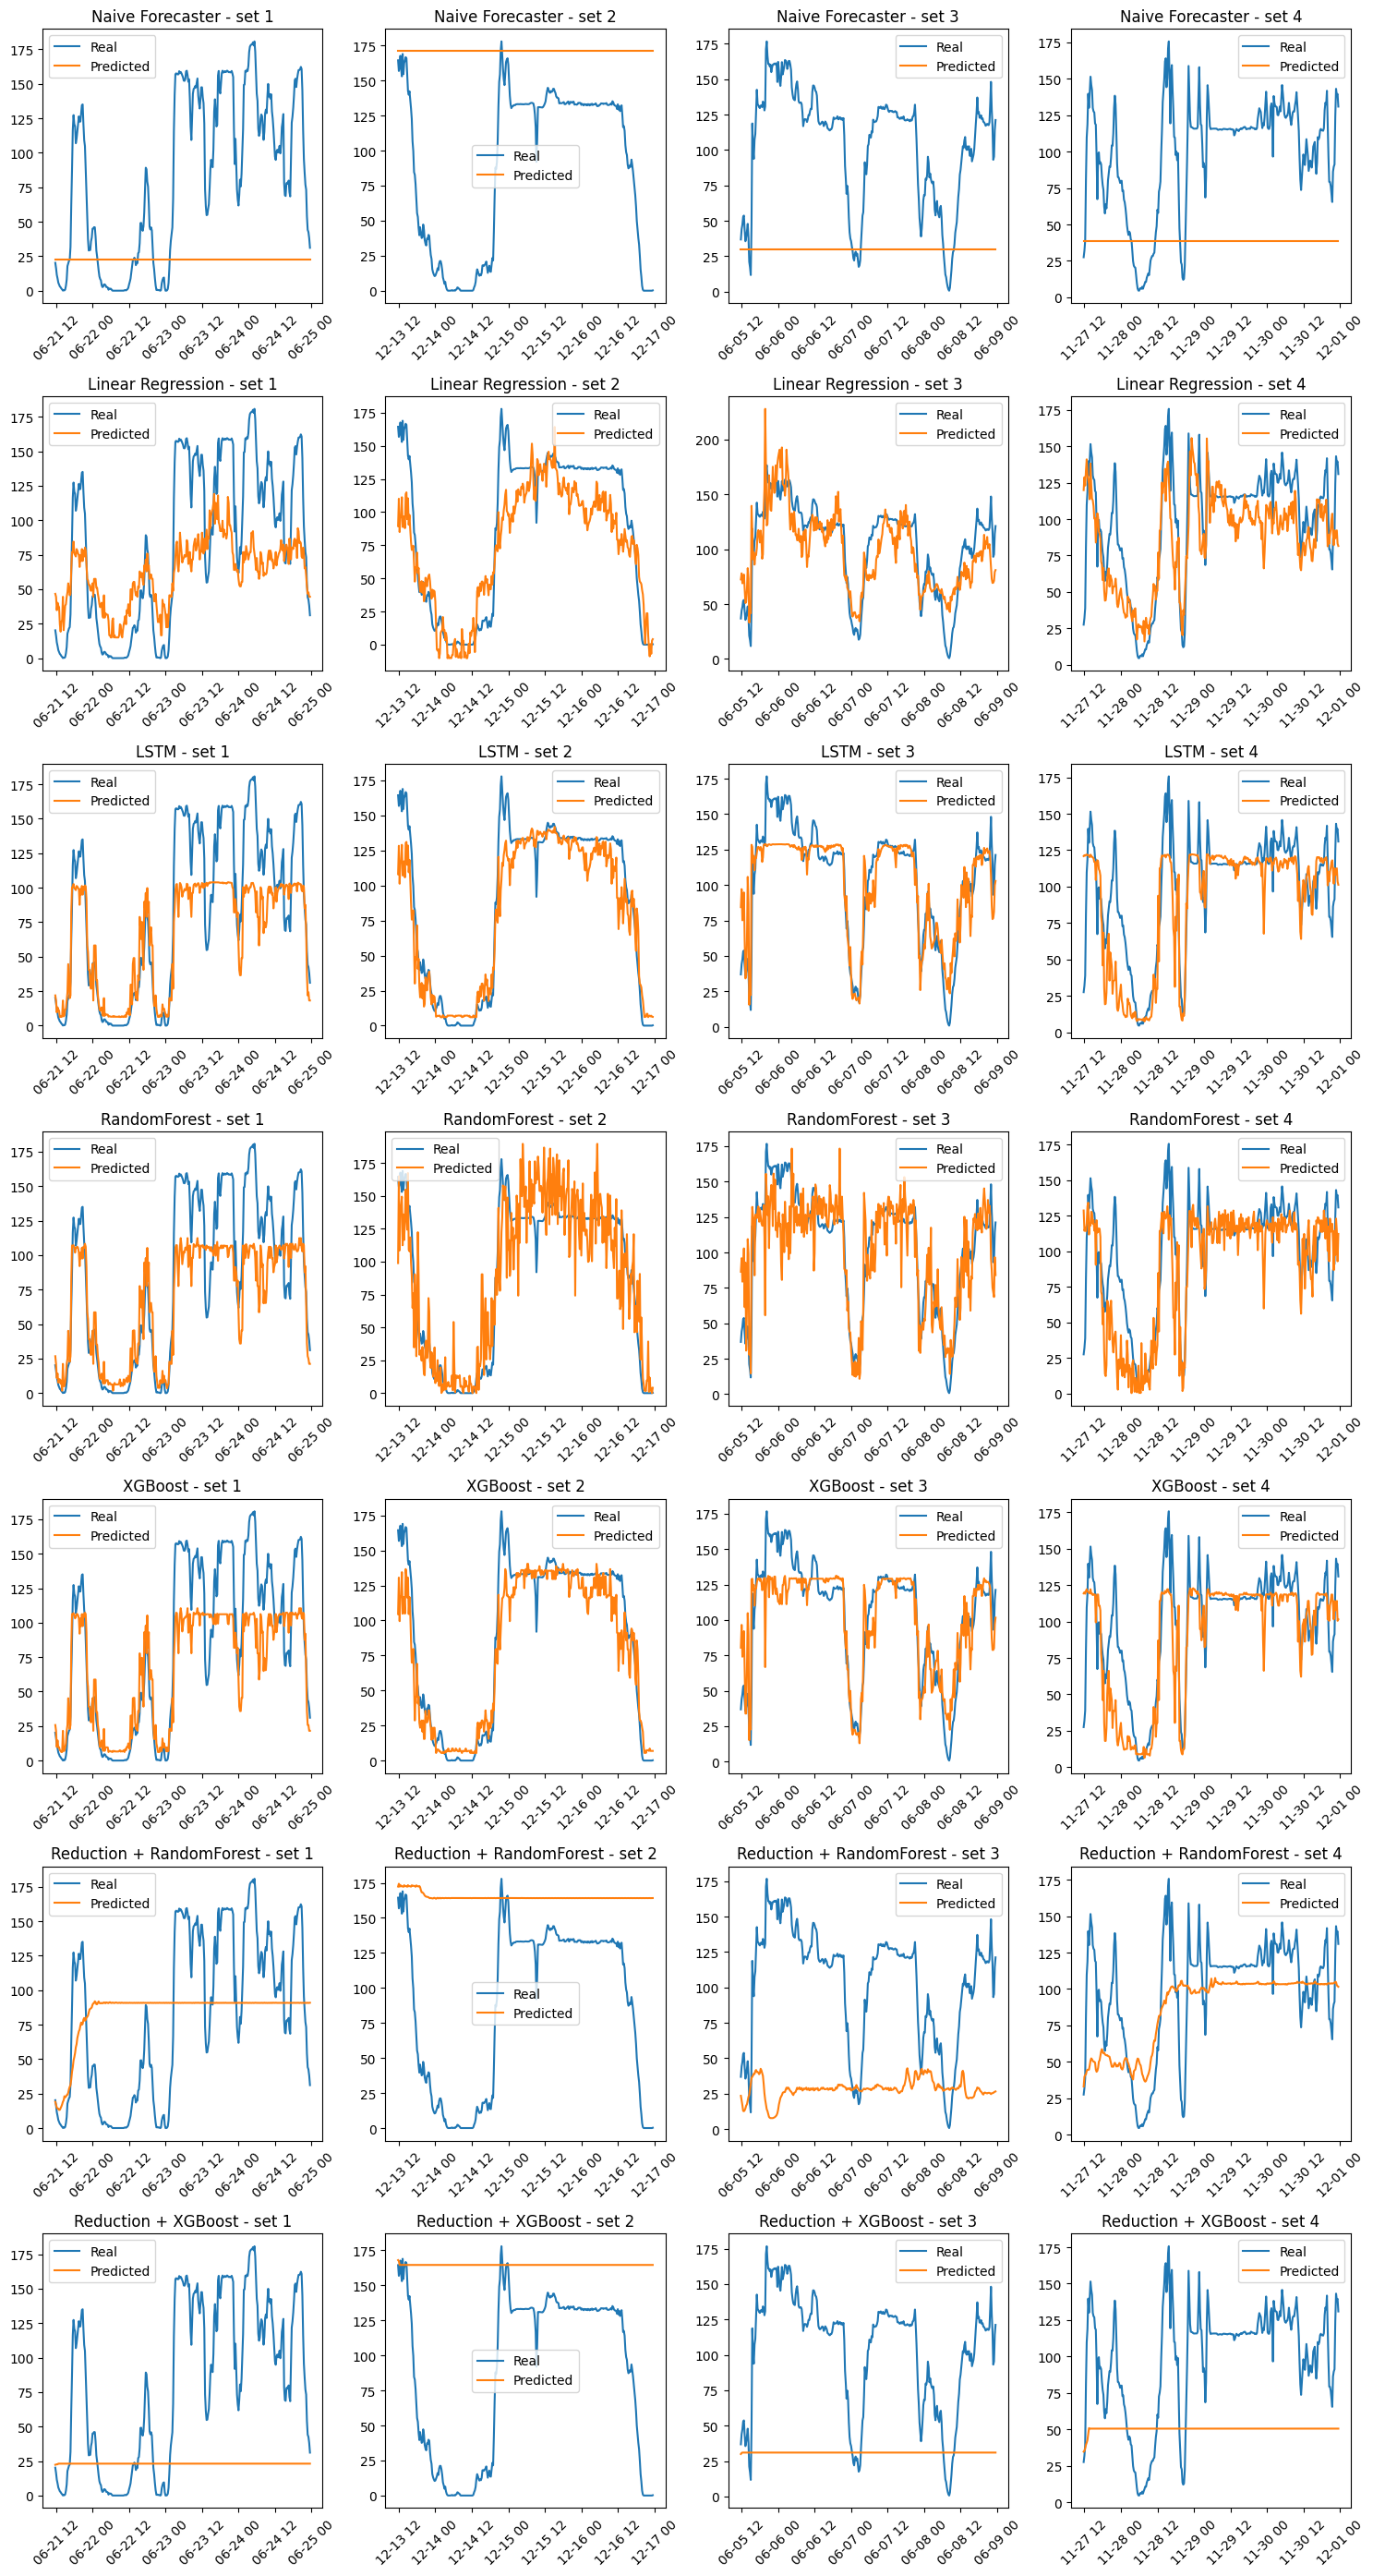

In [143]:
plt.figure(figsize=(15, 28))

# Plot Naive Forecaster
plt.subplot(7, 4, 1)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_naive_1, label='Predicted')
plt.title('Naive Forecaster - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 2)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_naive_2, label='Predicted')
plt.title('Naive Forecaster - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 3)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_naive_3, label='Predicted')
plt.title('Naive Forecaster - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 4)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_naive_4, label='Predicted')
plt.title('Naive Forecaster - set 4')
plt.legend()
plt.xticks(rotation=45)

# Plot Linear Regression
plt.subplot(7, 4, 5)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_linear_1, label='Predicted')
plt.title('Linear Regression - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 6)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_linear_2, label='Predicted')
plt.title('Linear Regression - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 7)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_linear_3, label='Predicted')
plt.title('Linear Regression - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 8)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_linear_4, label='Predicted')
plt.title('Linear Regression - set 4')
plt.legend()
plt.xticks(rotation=45)

# Plot LSTM
plt.subplot(7, 4, 9)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_lstm_1, label='Predicted')
plt.title('LSTM - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 10)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_lstm_2, label='Predicted')
plt.title('LSTM - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 11)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_lstm_3, label='Predicted')
plt.title('LSTM - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 12)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_lstm_4, label='Predicted')
plt.title('LSTM - set 4')
plt.legend()
plt.xticks(rotation=45)

# Plot RandomForest
plt.subplot(7, 4, 13)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_randomforest_1, label='Predicted')
plt.title('RandomForest - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 14)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_randomforest_2, label='Predicted')
plt.title('RandomForest - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 15)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_randomforest_3, label='Predicted')
plt.title('RandomForest - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 16)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_randomforest_4, label='Predicted')
plt.title('RandomForest - set 4')
plt.legend()
plt.xticks(rotation=45)

# Plot XGBoost
plt.subplot(7, 4, 17)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_xgboost_1, label='Predicted')
plt.title('XGBoost - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 18)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_xgboost_2, label='Predicted')
plt.title('XGBoost - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 19)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_xgboost_3, label='Predicted')
plt.title('XGBoost - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 20)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_xgboost_4, label='Predicted')
plt.title('XGBoost - set 4')
plt.legend()
plt.xticks(rotation=45)

# Plot Reduction + RandomForest
plt.subplot(7, 4, 21)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_reduction_randomforest_1, label='Predicted')
plt.title('Reduction + RandomForest - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 22)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_reduction_randomforest_2, label='Predicted')
plt.title('Reduction + RandomForest - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 23)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_reduction_randomforest_3, label='Predicted')
plt.title('Reduction + RandomForest - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 24)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_reduction_randomforest_4, label='Predicted')
plt.title('Reduction + RandomForest - set 4')
plt.legend()
plt.xticks(rotation=45)

# Plot Reduction + XGBoost
plt.subplot(7, 4, 25)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_reduction_xgboost_1, label='Predicted')
plt.title('Reduction + XGBoost - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 26)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_reduction_xgboost_2, label='Predicted')
plt.title('Reduction + XGBoost - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 27)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_reduction_xgboost_3, label='Predicted')
plt.title('Reduction + XGBoost - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 28)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_reduction_xgboost_4, label='Predicted')
plt.title('Reduction + XGBoost - set 4')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## **Backtesting**

In [144]:
#model_lstm.update(df_wf1_test)